In [21]:
#import importlib
import claims_over_time_plot
import get_data
import numpy as np
import pandas as pa
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import MaxNLocator, FuncFormatter, FormatStrFormatter, StrMethodFormatter 

In [22]:
from get_data import get_data,get_data_withcovid, fix_dates
import pandas as pd
from claims_over_time_plot import summarize
# from bayes_estimate import estimate_regression
import gc

In [23]:
def format_atts(use_gpi='covid'):
    
    atts = pa.read_csv("../Processed Data/regression/IVM_Regression_Dataset_per_untransformed_claim_False_" + use_gpi + ".csv")
    
    atts = fix_dates(atts)
    
    atts.fillna(0, inplace=True)
    
    atts = atts.groupby(["trump_binary_2016", "time_index", "week_date"], as_index=False).sum()
    atts.att = atts.att / atts.total_pop * 100000
    atts["covid_cases"] = atts.cases / atts.total_pop * 100000

    return atts


In [24]:
def format_xaxis(ax,  labels, end_time_index, tick_spacing):
    """
    Handles x axis labels precisely
    ax is the axes from ax, plt
    positions - list of integers that directly map to each xtick. Play with this to define which ticks to show.
    labels  -  a list to index indices from positions. 
    returns ax
    """

    positions = [ x for x in range(0, end_time_index,tick_spacing)]+[end_time_index]

    ax.xaxis.set_major_locator(MaxNLocator(len(positions)))
    ax.xaxis.set_ticks(positions)
    ax.xaxis.set_ticklabels([ labels[x] for x in positions],rotation=90)
    return ax

def format_yaxis(ax, rounding='integer'):
    if rounding=='integer':
        ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

    else:
        ax.set_yticklabels(['{:,}'.format(pa.np.round(x,2)) for x in ax.get_yticks().tolist()])
    return ax



def att_by_trump_support(y_all_red, y_all_blue, title="", y_label_red="", y_label_blue="", use_gpi='covid', xname='Weeks', opath='./graphs/',suffix='', time_labels=[],drug_name="ivermectin", treat_pos=0):
    
    
    font = {'family' : 'Times New Roman',
            'size'   : 14}
    
    plt.rc('font', **font)
    #plt.rc('axes', labelsize=28)
    fig, ax = plt.subplots(figsize=(15,8))

    
    tick_spacing=4

    colors= ['black','blue',"red","green",'yellow','brown','aqua','darkgreen']
    
    colors_= ['black',"green",'purple','saddlebrown','midnightblue','orange','forestgreen','firebrick','midnightblue'] # sandybrown -> firebrick
    # colors_[2] - yellow -> purple
    # colors_[3] - brown -> purple

    #time = [Week(t // 100, t % 100).sunday() for t in time_labels]
    
    from important_dates import get_time_indices
    
    event_lines = get_time_indices(drug=drug_name)
    
    y_max = max(y_all_red)
    y_min = min(y_all_red)
    
    labels_ = time_labels
    
    trend_ = [x for x in range(len(time_labels))]
    
    time = trend_
    end_time_index = max(trend_)

    if drug_name == "hydroxychlroquine":
        ax.plot_date(time, y_all, lw =1.5, color=colors[2], label = 'Actual HCQ Claims (Red States)', linestyle="-", marker='')
    
    elif drug_name == "ivermectin":
        ax.plot_date(time, y_all_red, lw =1.5, color=colors[2], label = 'Actual IVM Claims (Red States)', linestyle="-", marker='')

    y_pos = y_max * 0.75 + y_min * 0.25
    # print("y pos", y_pos)
    
    for ix,vl in enumerate(list(event_lines)): 
        if vl > labels_[0]:
            vline_position = labels_.index(vl)
            # print(vline_position)
            ax.axvline(vline_position, color=colors_[ix], linestyle='--',  label=event_lines[vl], lw=2)
            ax.annotate("Event " + event_lines[vl].split(":")[0], xy =(vline_position-1.5, y_pos), rotation=90 , fontsize=10)


    #ax.xaxis.set_ticks(np.array(time)[::5])
    ax.set_xlabel('Week (Sunday)', font=font)
    ax.xaxis.labelpad = 20

    ax.tick_params(axis='x', rotation=90, labelsize=14)
    
    ax.tick_params(axis='y', labelsize=14)

    ax.yaxis.labelpad = 5
    # ax.yaxis.set_ticks([0, 50] + list(np.arange(100, 750, 100)))
    # ax.set_yticklabels(np.array([0, 50] + list(np.arange(100, 750, 100))).astype(str))
    ax.set_ylabel(y_label_red, font=font)
    
    ax.set_title(title, fontdict={"fontsize" : 18, "fontweight" : "bold", "fontfamily":"Times New Roman"})
    # ax.grid()
    
    ax = format_xaxis(ax,  time_labels, end_time_index, tick_spacing)
    if y_all_red.mean() > 1:
        ax = format_yaxis(ax)

    font2 = {'family' : 'Times New Roman',
           'size'   : 14}
    fig.legend(loc='upper center', ncol=4, prop=font2, bbox_to_anchor=(0.5, -0.05))
    
    if not os.path.exists('{}'.format(opath)):
        os.makedirs('{}'.format(opath))

    print("FILEPATH",'{}/{}'.format(opath,suffix )+'.png')
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel(y_label_blue, font=font)  # we already handled the x-label with ax1

    if drug_name == "hydroxychlroquine":
        ax2.plot_date(time, y_all, lw =1.5, color=colors[2], label = 'Actual HCQ Claims (Red States)', linestyle="-", marker='')
    
    elif drug_name == "ivermectin":
        ax2.plot_date(time, y_all_blue, lw =1.5, color=colors[1], label = 'Actual IVM Claims (Blue States)', linestyle="-", marker='')

    ax2.yaxis.labelpad = 5
    if y_all_blue.mean() > 1:
        ax2 = format_yaxis(ax2)
    ax2.xaxis.set_ticks(np.array(time))
    ax2.set_xlabel('Week (Sunday)', font=font)
    ax2.xaxis.labelpad = 20
    ax2.tick_params(axis='y', labelsize=14)
    ax2.xaxis.set_ticks(np.array(time))
    fig.legends = []

    fig.legend(loc='upper center', ncol=3, prop=font2, bbox_to_anchor=(0.5, -0.05))
    fig.savefig("graphs/att_by_trump_support_" + use_gpi + ".png",bbox_inches='tight',dpi=300)
    
    return

def covid_by_trump_support(covid_cases_red, covid_cases_blue, title="", covid_label_red="", covid_label_blue="", use_gpi="covid", xname='Weeks', opath='./graphs/',suffix='', time_labels=[],drug_name="ivermectin", treat_pos=0):
    
    font = {'family' : 'Times New Roman',
            'size'   : 14}
    plt.rc('font', **font)
    #plt.rc('axes', labelsize=28)
    fig, ax = plt.subplots(figsize=(15,8))

    
    tick_spacing=4

    colors= ['black','blue',"red","green",'yellow','brown','aqua','darkgreen']
    
    colors_= ['black',"green",'purple','saddlebrown','midnightblue','orange','forestgreen','firebrick','midnightblue'] # sandybrown -> firebrick
    # colors_[2] - yellow -> purple
    # colors_[3] - brown -> purple

    #time = [Week(t // 100, t % 100).sunday() for t in time_labels]
    
    from important_dates import get_time_indices
    
    event_lines = get_time_indices(drug=drug_name)
    
    y_max = max(covid_cases_red)
    y_min = 0
    
    
    """
    if drug_name=='hydroxychloroquine' or drug_name=='chloroquine phosphate':
        y_max=70
    elif drug_name=='ivermectin':
        y_max=400
    """
    labels_ = time_labels
    
    trend_ = [x for x in range(len(time_labels))]
    
    time = trend_
    end_time_index = max(trend_)


    #time = pa.to_datetime(time.values)
    if drug_name == "hydroxychlroquine":
        ax.plot_date(time, y_all, lw =1.5, color=colors[2], label = 'Actual HCQ Claims', linestyle="-", marker='')
    
    elif drug_name == "ivermectin":
        covid_cases_red = [0] * (len(time) - len(covid_cases_red)) + list(covid_cases_red)
        # ax.plot_date(time[-covid_cases_red.shape[0]:], covid_cases_red, lw =1, color=colors[2], label = 'Weekly Covid Cases (Red States)', linestyle="--", marker='')
        ax.plot_date(time, covid_cases_red, lw =1, color=colors[2], label = 'Weekly Covid Cases (Red States)', linestyle="--", marker='')
    
    # y_max = 1205
    # y_min = 430
    
    y_pos = y_max * 0.75 + y_min * 0.25
    # print("y pos", y_pos)
    
    
    
    for ix,vl in enumerate(list(event_lines)):
        if vl > labels_[0]:
            vline_position = labels_.index(vl)
            # print(vline_position)
            ax.axvline(vline_position, color=colors_[ix], linestyle='--',  label=event_lines[vl], lw=2)
            ax.annotate("Event " + event_lines[vl].split(":")[0], xy =(vline_position-1.5, y_pos), rotation=90 , fontsize=14)

    ax.set_xlabel('Week (Sunday)', font=font)
    ax.xaxis.labelpad = 20

    ax.tick_params(axis='x', rotation=90, labelsize=14)
    
    ax.tick_params(axis='y', labelsize=14)

    ax.yaxis.labelpad = 5

    ax.set_ylabel(covid_label_red, font=font)
    
    ax.set_title(title, fontdict={"fontsize" : 18, "fontweight" : "bold", "fontfamily":"Times New Roman"})
    # ax.grid()
    
    ax = format_xaxis(ax,  time_labels, end_time_index, tick_spacing)
    if np.mean(covid_cases_red) > 1:
        ax = format_yaxis(ax)

    font2 = {'family' : 'Times New Roman',
           'size'   : 14}
    fig.legend(loc='upper center', ncol=4, prop=font2, bbox_to_anchor=(0.5, -0.05))
    
    if not os.path.exists('{}'.format(opath)):
        os.makedirs('{}'.format(opath))
    # print("FILEPATH",'{}/{}'.format(opath,suffix )+'.png')
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel(covid_label_blue, font=font)  # we already handled the x-label with ax1

    covid_cases_blue = [0] * (len(time) - len(covid_cases_blue)) + list(covid_cases_blue)
    ax2.plot_date(time, covid_cases_blue, lw =1, color=colors[1], label = 'Weekly Covid Cases (Blue States)', linestyle="--", marker='')
    ax2.yaxis.labelpad = 5
    if np.mean(covid_cases_blue) > 1:
        ax2 = format_yaxis(ax2)
    ax2.xaxis.set_ticks(np.array(time))
    ax2.set_xlabel('Week (Sunday)', font=font)
    ax2.xaxis.labelpad = 20
    ax2.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', rotation=90, labelsize=14)
    ax2.xaxis.set_ticks(np.array(time))
    fig.legends = []
    plt.tight_layout()
    fig.legend(loc='upper center', ncol=3, prop=font2, bbox_to_anchor=(0.5, -0.05))
    fig.savefig("graphs/covid_by_trump_support_" + use_gpi + ".png",bbox_inches='tight',dpi=300)
    
    return

covid: 6.7435219877979
FILEPATH ./graphs//.png


/tmp/ipykernel_2350298/148001132.py:66: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(time, y_all_red, lw =1.5, color=colors[2], label = 'Actual IVM Claims (Red States)', linestyle="-", marker='')
/tmp/ipykernel_2350298/148001132.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
/tmp/ipykernel_2350298/148001132.py:115: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot_date(time, y_all_blue, lw =1.5, color=colors[1], label = 'Actual IVM Claims (Blue States)', linestyle="-", marker='')
/tmp/ipykernel_2350298/148001132.py:180: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker=

gpi: 6.687776285466908
FILEPATH ./graphs//.png


/tmp/ipykernel_2350298/148001132.py:66: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(time, y_all_red, lw =1.5, color=colors[2], label = 'Actual IVM Claims (Red States)', linestyle="-", marker='')
/tmp/ipykernel_2350298/148001132.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
/tmp/ipykernel_2350298/148001132.py:115: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax2.plot_date(time, y_all_blue, lw =1.5, color=colors[1], label = 'Actual IVM Claims (Blue States)', linestyle="-", marker='')
/tmp/ipykernel_2350298/148001132.py:180: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker=

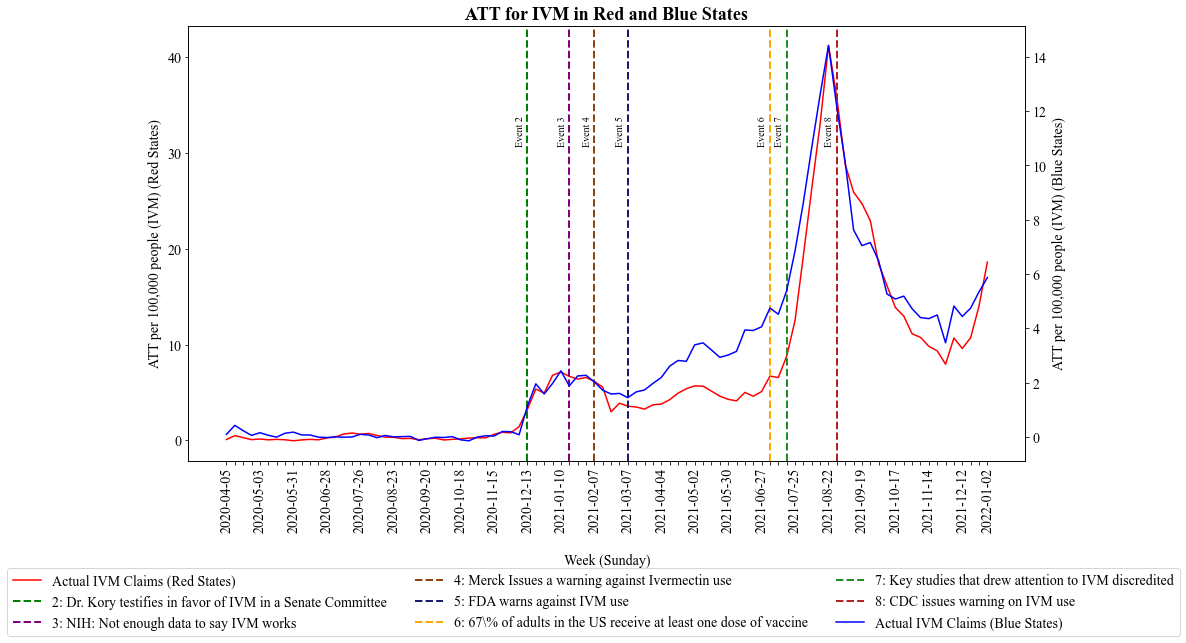

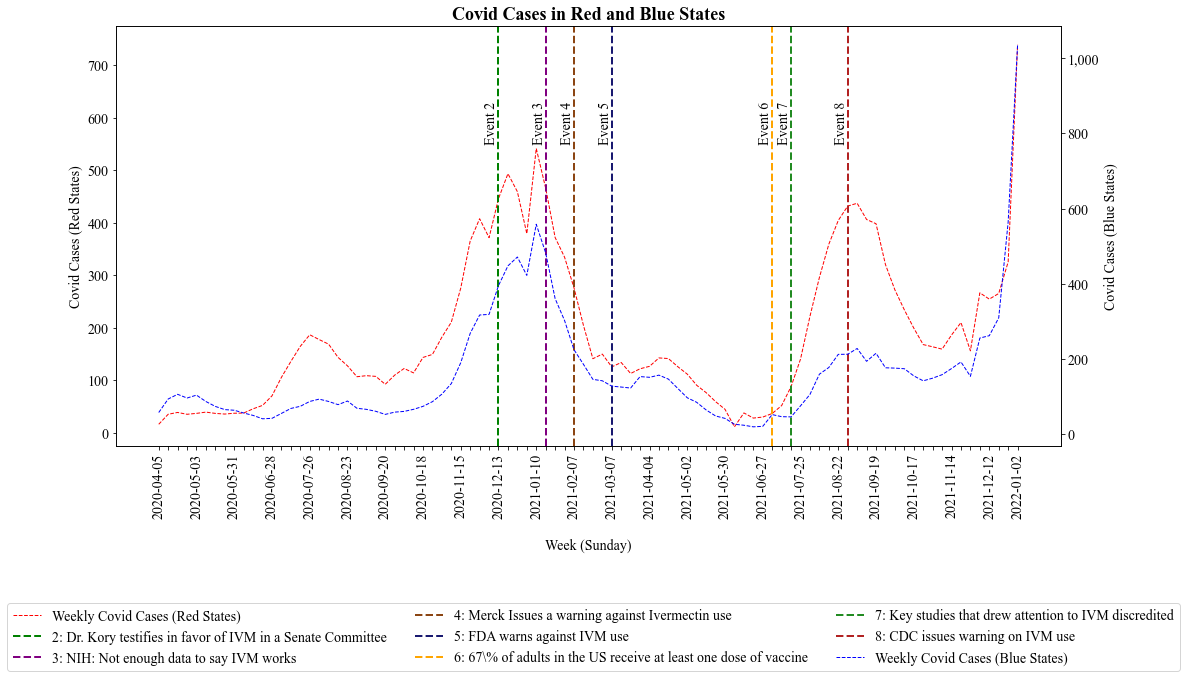

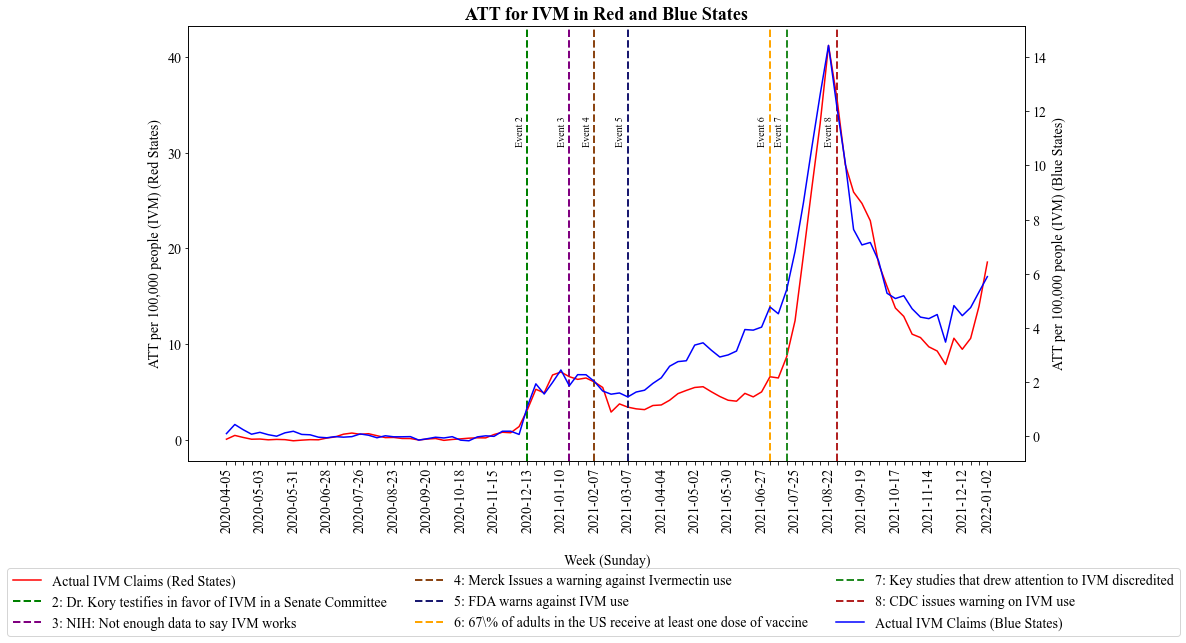

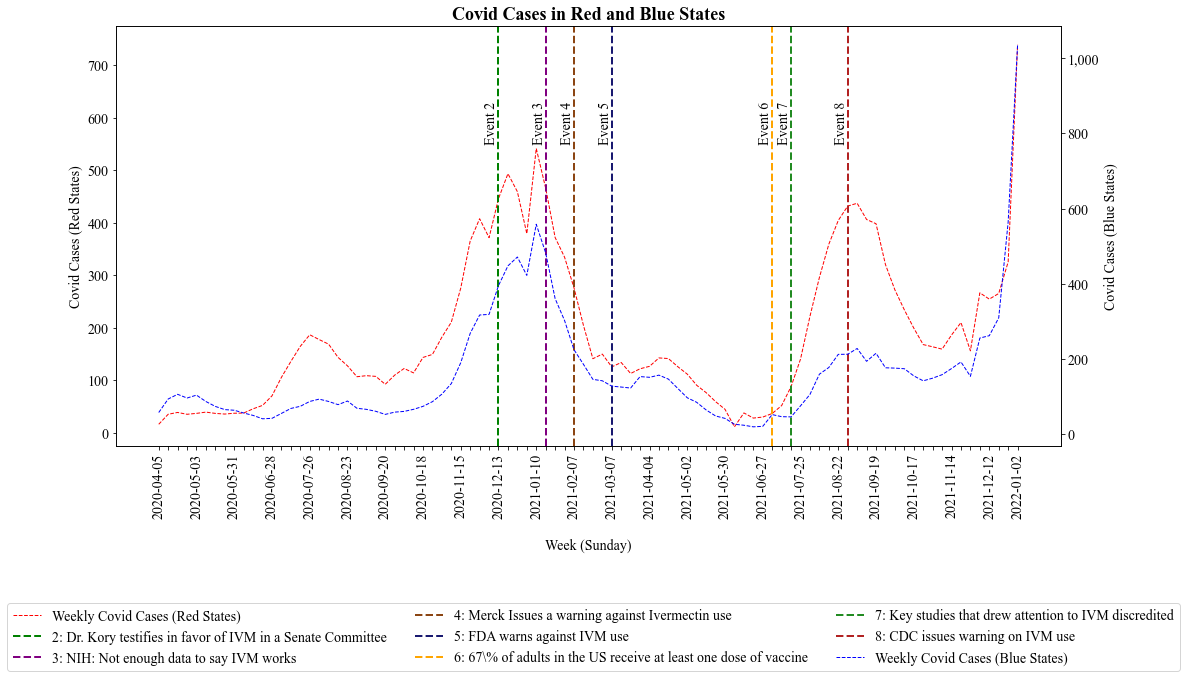

In [25]:
for use_gpi in ["covid", "gpi"]:
    atts = format_atts(use_gpi=use_gpi)
    print(use_gpi + ":", atts[atts.trump_binary_2016 == 1].att.values.mean())
    
    time_labels = atts[atts.trump_binary_2016 == 1].week_date.to_list()
    
    y_all_red = atts[atts.trump_binary_2016 == 1].att.values
    y_all_blue = atts[atts.trump_binary_2016 == 0].att.values
    
    covid_cases_red = atts[atts.trump_binary_2016 == 1].covid_cases.values
    covid_cases_blue = atts[atts.trump_binary_2016 == 0].covid_cases.values
    
    title="ATT for IVM in Red and Blue States"
    covid_title = "Covid Cases in Red and Blue States"
    
    y_label_red="ATT per 100,000 people (IVM) (Red States)"
    y_label_blue="ATT per 100,000 people (IVM) (Blue States)"
    
    covid_label_red = "Covid Cases (Red States)"
    covid_label_blue = "Covid Cases (Blue States)"
    
    att_by_trump_support(y_all_red=y_all_red, y_all_blue=y_all_blue, title=title, y_label_red=y_label_red, y_label_blue=y_label_blue, use_gpi=use_gpi, time_labels=time_labels)
    covid_by_trump_support(covid_cases_red=covid_cases_red, covid_cases_blue=covid_cases_blue, title=covid_title, covid_label_red=covid_label_red, covid_label_blue=covid_label_blue, use_gpi=use_gpi, time_labels=time_labels)
